In [49]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sksurv.preprocessing import OneHotEncoder
from sksurv.linear_model import CoxPHSurvivalAnalysis
import error_function 

In [50]:
pd.set_option('display.max_columns', 500)

In [51]:
train = pd.read_csv("datasets/train.csv",  index_col='ID')
test = pd.read_csv("datasets/test.csv", index_col='ID')

In [73]:
x_train = train[['age', 'cutaneous_biopsy_breslow']]
y_train = train[['specific_death', 'months_survival']]
y_train.dtypes
test.head()

,patient_gender,patient_eye_color,patient_hair_color,patient_phototype,primary_tumour_location_coded,T0_date,cutaneous_biopsy_breslow,cutaneous_biopsy_ulceration,cutaneous_biopsy_satellitosis,cutaneous_biopsy_vascular_invasion,cutaneous_biopsy_neurotropism,cutaneous_biopsy_lymphatic_invasion,cutaneous_biopsy_predominant_cell_type,cutaneous_biopsy_associated_nevus,cutaneous_biopsy_mitotic_index,cutaneous_biopsy_histological_subtype,cutaneous_biopsy_regression,count_inv_prec_tumour,count_situ_prec_tumour,slnb_ldn_location_total,total_count_slnb_ldn,total_positives_slnb_ldn,scenario,visceral_metastasis_location,MC1R,age,LAB1300,LAB1301,LAB1307,LAB1309,LAB1311,LAB1313,LAB1314,LAB1316,LAB2404,LAB2405,LAB2406,LAB2407,LAB2419,LAB2422,LAB2467,LAB2469,LAB2476,LAB2498,LAB2544,LAB2679,LAB4176,neutrofils_per_limfocits,limfocits_per_monocits,LABGF_filtrat_glomerular
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
ID108,female,brown,brown,2.0,lower limbs,2003-11-07,0.50,absent,absent,absent,absent,absent,NaN,absent,0.0,superficial_spreading,NaN,0.0,0.0,NaN,NaN,NaN,scenario1,NaN,0.0,35.519126,3.4,244.0,0.8,2.19,0.27,0.01,12.5,0.03,20.0,20.0,14.0,0.3,NaN,92.0,1.0,181.0,99.0,71.0,1.4,0.04,6.7,0.365297,8.111111,66.861022
ID134,female,brown,black,3.0,trunk,2003-07-10,0.75,absent,NaN,NaN,NaN,NaN,NaN,NaN,0.0,superficial_spreading,NaN,0.0,0.0,NaN,NaN,NaN,scenario1,NaN,NaN,82.435616,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ID292,female,green,brown,2.0,acral,1998-07-01,1.80,absent,absent,absent,absent,absent,NaN,absent,0.0,superficial_spreading,NaN,0.0,1.0,NaN,2.0,0.0,scenario2,NaN,NaN,59.830137,2.8,249.0,1.7,0.79,0.20,0.04,13.4,0.00,28.0,30.0,16.0,0.6,409.0,93.0,0.9,258.0,54.0,63.0,1.6,NaN,NaN,2.151899,3.950000,67.921338
ID306,female,green,brown,3.0,lower limbs,1999-03-04,2.45,absent,absent,absent,absent,absent,NaN,absent,0.0,superficial_spreading,NaN,0.0,0.0,NaN,1.0,0.0,scenario2,NaN,0.0,66.169863,6.2,223.0,3.8,1.78,0.37,0.05,14.3,0.05,23.0,27.0,12.0,0.9,311.0,95.0,0.9,228.0,73.0,71.0,1.7,0.18,NaN,2.134831,4.810811,66.546768
ID308,male,NaN,NaN,NaN,trunk,1999-01-29,4.20,absent,absent,absent,absent,absent,fusocellular,absent,0.0,superficial_spreading,absent,0.0,0.0,NaN,NaN,NaN,scenario1,NaN,NaN,38.161644,5.4,236.0,3.8,1.09,0.40,0.05,14.5,0.03,19.0,26.0,16.0,1.2,277.0,103.0,1.0,215.0,66.0,71.0,1.0,0.10,NaN,3.486239,2.725000,NaN


In [71]:
def fit_and_prepare(x_train, y_train, test_df):
    
    # 3.1. Prepare Y-----
    y_train['specific_death'] = y_train['specific_death'].astype(bool)
    
    # Transform it into a structured array
    y_train = y_train.to_records(index = False)
    
    # 3.2. Prepare X-----
    # obtain the x variables that are categorical
    categorical_feature_mask = x_train.dtypes==object

    # Filter categorical columns using mask and turn it into a list
    categorical_cols = x_train.columns[categorical_feature_mask].tolist()

    # Ensure categorical columns are category type
    for col in categorical_cols:
        x_train[col] = x_train[col].astype('category')
        test_df[col] = test_df[col].astype('category')
    
    # 3.3. Fit model-----
    # initiate
    encoder = OneHotEncoder()
    estimator = CoxPHSurvivalAnalysis()
    
    # fit model
    estimator.fit(encoder.fit_transform(x_train), y_train)
    
    # transform the test variables to match the train
    x_test = encoder.transform(test_df)
    
    return (estimator, x_test, x_train, y_train)

In [72]:
estimator, x_test, x_train, y_train = fit_and_prepare(x_train, y_train, test)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [40]:
estimator

CoxPHSurvivalAnalysis(alpha=0, n_iter=100, tol=1e-09, verbose=0)

In [6]:
def get_probabilities(x_test, estimator):
    
    pred_surv = estimator.predict_survival_function(x_test)

    # Get the "X's" or time of each data point
    times = pred_surv[0].x

    # Create an empty pandas dataframes with these times as the columns
    pred_df = pd.DataFrame(columns = times)

    # Convert each row to a pandas series row (transpose) with the index as these x times and append it to the df
    for i in range(0, len(x_test)):
        pred_df = pred_df.append(pd.DataFrame(pred_surv[i].y).set_index(times).T) 

    pred_df = pred_df.set_index(x_test.index)

    return pred_df

In [48]:
predictions = get_probabilities(x_test, estimator)
predictions.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
ID108,1.0,1.0,0.999749,0.999497,0.998992,0.997726,0.996707,0.995682,0.994139,0.992578,0.992055,0.991266,0.990211,0.988088,0.987020,0.986213,0.984319,0.981599,0.980504,0.979405,0.976925,0.975535,0.974975,0.973293,0.972446,0.969883,0.967874,0.965854,0.964397,0.963226,0.961464,0.959986,0.959390,0.955813,0.953408,0.950992,0.948560,0.945810,0.943660,0.942421,0.941483,0.940851,0.938624,0.937011,0.936036,0.935049,0.934054,0.933051,0.932039,0.931017,0.929293,0.927550,0.926141,0.925429,0.924714,0.923995,0.923995,0.922166,0.921058,0.919567,0.919191,0.918408,0.917219,0.916818,0.915603,0.915603,0.913542,0.913125,0.912703,0.911417,0.909674,0.907023,0.905673,0.904308,0.903847,0.903847,0.902427,0.900520,0.899556,0.898585,0.898585,0.898090,0.897088,0.896580,0.895562,0.893504,0.892982,0.892452,0.891916,0.890832,0.890832,0.890275,0.889692,0.889692,0.887905,0.886701,0.886701,0.886701,0.886701,0.886069,0.885425,0.885425,0.885425,0.883426,0.883426,0.883426,0.883426,0.882722,0.882013,0.882013,0.882013,0.880544,0.880544,0.879044,0.879044,0.879044,0.879044,0.878257,0.878257,0.878257,0.876605,0.876605,0.876605,0.875732,0.875732,0.874835,0.874835,0.874835,0.873895,0.873895,0.873895,0.872912,0.872912,0.872912,0.871898,0.870875,0.870875,0.870875,0.870875,0.870875,0.870875,0.869793,0.869793,0.869793,0.869793,0.869793,0.869793,0.869793,0.869793,0.868582,0.867336,0.867336,0.867336,0.867336,0.867336,0.867336,0.867336,0.867336,0.867336,0.867336,0.867336,0.867336,0.867336,0.867336,0.867336,0.867336,0.867336,0.867336,0.867336,0.864101,0.862465,0.862465,0.862465,0.862465,0.862465,0.862465,0.862465,0.862465,0.862465,0.860552,0.860552,0.860552,0.860552,0.860552,0.860552,0.860552,0.860552,0.858329,0.858329,0.858329,0.858329,0.858329,0.858329,0.858329,0.858329,0.858329,0.858329,0.858329,0.858329,0.858329,0.858329,0.858329,0.858329,0.858329,0.858329,0.858329,0.858329,0.858329,0.858329,0.858329,0.858329,0.858329,0.858329,0.858329,0.858329,0.858329,0.858329,0.858329,0.858329,0.858329,0.858329,0.858329,0.858329,0.858329,0.858329,0.858329,0.858329,0.858329,0.858329,0.858329,0.850944,0.850944,0.850944,0.850944,0.850944,0.850944,0.850944,0.850944,0.850944,0.850944,0.850944,0.850944,0.850944,0.850944,0.850944,0.850944,0.850944,0.850944,0.850944,0.850944,0.850944,0.850944,0.850944,0.850944
ID134,1.0,1.0,0.999316,0.998629,0.997253,0.993807,0.991041,0.988263,0.984089,0.979880,0.978470,0.976349,0.973516,0.967834,0.964982,0.962831,0.957794,0.950589,0.947698,0.944803,0.938289,0.934652,0.933190,0.928804,0.926600,0.919953,0.914762,0.909564,0.905823,0.902826,0.898327,0.894564,0.893050,0.883994,0.877938,0.871883,0.865813,0.858981,0.853663,0.850610,0.848300,0.846749,0.841291,0.837354,0.834978,0.832576,0.830163,0.827732,0.825285,0.822819,0.818669,0.814485,0.811113,0.809413,0.807709,0.805997,0.805997,0.801650,0.799026,0.795502,0.794614,0.792769,

In [8]:
pred_curves = estimator.predict_survival_function(x_test)
# pred_curves

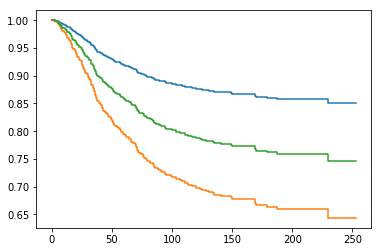

In [9]:
for curve in pred_curves[0:3]:
    plt.step(curve.x, curve.y, where="post")

In [34]:


# To be filled
predictions_train = get_probabilities(x_train, estimator)
# Here 'x_train' was already processed by encoder in function 'fit_and_prepare'. To use on your data (x_2use), first run 'x_2use = encoder.transform(x_df_2use)'

# Using the different module error_functions obtain the error matrix for y_test

In [46]:

weights = error_function.calc_weights(train[['specific_death', 'months_survival']]) 
weights

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253
0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,4.634503e-01,2.115305e-01,9.569236e-02,4.281730e-02,1.912292e-02,8.524673e-03,3.735239e-03,1.630234e-03,7.044222e-04,2.976432e-04,1.241356e-04,5.084592e-05,2.048646e-05,8.093832e-06,3.149090e-06,1.202668e-06,4.530319e-07,1.692140e-07,6.247900e-08,2.279785e-08,8.142088e-09,2.880388e-09,1.002538e-09,3.477831e-10,1.190274e-10,4.031572e-11,1.351121e-11,4.511868e-12,1.484815e-12,4.813410e-13,1.548432e-13,4.903366e-14,1.515085e-14,4.661800e-15,1.391450e-15,4.134594e-16,1.211864e-16,3.502497e-17,9.880584e-18,2.759616e-18,7.550918e-19,2.033515e-19,5.417315e-20,1.387095e-20,3.403914e-21,7.980130e-22,1.806822e-22,3.791617e-23,7.763010e-24,1.549234e-24,2.983208e-25,5.531776e-26,9.935119e-27,1.748050e-27,3.043480e-28,5.242683e-29,8.440601e-30,1.244697e-30,1.711821e-31,2.144835e-32,2.371692e-33,2.365922e-34,2.256013e-35,1.795832e-36,1.179081e-37,7.182221e-39,3.683190e-40,1.708697e-41,6.657259e-43,1.751910e-44,2.795602e-46,2.989948e-48,1.607499e-50,4.332882e-53,0.0
1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000

In [35]:
error = error_function.brier_score_loss_weighted(pred = predictions_train,
                                                 actual = train[['specific_death', 'months_survival']], 
                                                 weights = weights, 
                                                 years_cutoff = 10)


print("Overall error: ", error)

Overall error:  0    0.079905
dtype: float64
